In [1]:
#Train, val, Test splitter
import train_pytorch
import prepare_dataset
import random
import time 
from collections import Counter
import os
import numpy as np
import shutil
#os.chdir("/Users/kjartan/Documents/CompCogSci3/") 
os.chdir(r"C:\Users\kjart\OneDrive\Dokumenter\KU\3. semester\Cog sci 3\CompCogSci3")

In [2]:
language = "EN"
unsorted_data_dir = "raw_data/derivatives/"
annotation_file = f"raw_data/annotation/{language}/lpp{language}_word_information.csv"
random.seed(1234)

pos = "ADJ"
oov = "-1"
binary = False


In [27]:
#prepare_dataset.clear_data_dir()
#shutil.rmtree("aux_data/")
##the split is (0.8,0.1,0.1)
#prepare_dataset.fill_data_dir(unsorted_data_dir, prepare_dataset.config1, language)

In [3]:
#Move data back from aux_data/
for phase in os.listdir("aux_data/"):
    for run in os.listdir(f"aux_data/{phase}"):
        path = f"aux_data/{phase}/{run}/{language}/"
        for file in os.listdir(path):
            file_path = f"data/{phase}/{run}/{language}/{file}"
            shutil.move(f"aux_data/{phase}/{run}/{language}/{file}",file_path)
            #time.sleep(0.00001)

In [4]:


prepare_dataset.prepare_labels(annotation_file, "data/", language, pos=pos, oov=oov)

#binary = prepare_dataset.convert_to_binary_labels("data/", oov, language)

277  = number of classes


In [5]:
all_labels = []
for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                path = f"data/{i}/{run}/{language}/labels.txt"
                with open(path, "r") as f:
                    lines = f.readlines()
                    for l in lines:
                        all_labels.append(l.strip("\n"))

from collections import Counter
import codecs

most_common = Counter(all_labels).most_common()
label_dict = {}
with codecs.open("label_dict.txt", "r", encoding="utf-8") as f:
    for i in f.readlines():
        k = i.split("=")
        label_dict[k[1].strip("\n ")] = k[0]
most_common_lemmas = []
for i in range(len(most_common)):
    lbl = most_common[i][0]
    most_common_lemmas.append((label_dict[lbl], most_common[i][1]))



In [6]:
vocab15 = []
off_set = 1
label_stats = most_common_lemmas[off_set+1:15+off_set+1]
for w, _ in label_stats: #top 15 words
    vocab15.append(w.strip())
    
print(vocab15)
print(label_stats)

['good', 'other', 'important', 'old', 'small', 'same', 'first', 'beautiful', 'able', 'more', 'long', 'conceited', 'much', 'single', 'right']
[('good ', 1134), ('other ', 513), ('important ', 513), ('old ', 459), ('small ', 459), ('same ', 405), ('first ', 378), ('beautiful ', 378), ('able ', 351), ('more ', 351), ('long ', 324), ('conceited ', 324), ('much ', 297), ('single ', 297), ('right ', 243)]


In [7]:
vocab = vocab15
prepare_dataset.prepare_handpicked_labels(annotation_file, "data/", vocab, oov=oov)

16  = number of classes


In [8]:
#Exclude data that corresponds to oov
with codecs.open("label_dict.txt", "r", encoding="utf-8") as f:
    for i in f.readlines():
        k = i.split("=")
        if k[0].strip() == oov:
            label_2_remove = int(k[1].strip("\n "))
            break
print(label_2_remove)
labels_dict = {}
for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                labels = np.loadtxt(f"data/{i}/{run}/{language}/labels.txt")
                labels_dict[run] = labels

exclusion_idxs = {k:[] for k in range(9)}

for run in labels_dict.keys():
    for idx, label in enumerate(labels_dict[run]):
        if label==label_2_remove:
            exclusion_idxs[run].append(idx)


for i in os.listdir("data"):
    if os.path.isdir("data/"+i):
        for phase in os.listdir("data/"+i):
            for run in range(9):
                path = f"data/{i}/{run}/{language}/labels.txt"
                with open(path, "r") as f:
                    lines = f.readlines()
                with open(path, "w") as f:
                    for line in lines:
                        if line.strip("\n ") != str(label_2_remove):
                            f.write(line)

count = 0
for phase in os.listdir("data/"):
    for run in range(9):
        path = f"data/{phase}/{run}/{language}/"
        for file in os.listdir(path):
            if file.endswith(".txt"):
                continue
            file_path = f"data/{phase}/{run}/{language}/{file}"
            idx = file.split("_")[-1][:-4]
            if int(idx) in exclusion_idxs[run]:
                count +=1 
                dest = f"aux_data/{phase}/{run}/{language}/"
                if not os.path.exists(dest):
                    os.makedirs(dest)
                shutil.move(file_path, f"aux_data/{phase}/{run}/{language}/")
                #time.sleep(0.00001)
print("moved ", count, " files")


12
moved  108554  files


In [9]:

def count_files():
    counts = {}
    # Iterate directory
    for phase in os.listdir("data"):
        if os.path.isdir("data/"+phase):
            count=0
            for run in os.listdir(f"data/{phase}/"):
                for file in os.listdir(f"data/{phase}/{run}/{language}"):
                    if file.endswith(".npy"):
                        count += 1
        counts[phase] = count
    return counts

count_files()

{'Test': 247, 'Train': 11850, 'Val': 1493}

In [10]:
def calc_baseline(lbl = "data/Test/", language = "EN"):
    prob = 0
    labels = []
    for run in os.listdir(lbl):
        path = lbl +"/"+ run + "/" + language
        multiplier = len(os.listdir(path))-1
        if multiplier>0:
            for _ in range(int(multiplier/len(np.loadtxt(path+"/labels.txt")))):
                labels.append(np.loadtxt(path+"/labels.txt"))
    labels = np.concatenate(labels).ravel()
    total = labels.size
    label_c = Counter(labels)
    for _, v in label_c.items():
        prob += (v/total)**2
    return prob

calc_baseline()

0.07669309325450148

In [11]:
import json
import datetime
with codecs.open("config_stats.txt", "a", encoding="utf-8") as f:
    f.write("\n")
    f.write(f"{datetime.datetime.now()}\n")
    f.write(f"{off_set+1}th to {off_set+15}th\n")
    for i in label_stats:
        f.write(str(i) + ", ")
    f.write("\n")
    f.write(json.dumps(count_files()))
    f.write("\n")
f.close()

In [12]:
batch_size=50
config = f"config2_{language}_top15{pos}"

2022-12-11 12:52:20.704676


c:\Users\kjart\OneDrive\Dokumenter\KU\3. semester\Cog sci 3\CompCogSci3\mt_deep-master\scripts\model_m2dcnn.py:78: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))


cuda
Epoch 1/10
-------------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0EA40>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0FA30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0DF60>}
 84.39 %
 168.78 %
##### train Loss: 2.7489 Acc: 0.1030 #####
{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0EA40>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0FA30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0DF60>}
##### valid Loss: 2.7197 Acc: 0.1360 #####
Epoch 2/10
-------------
{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0EA40>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0FA30>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000012EA6D0DF60>}
 84.39 %
 168.78 %
##### train Loss: 2.6574 Acc: 0.1521 #####
{'train': <torch.utils.data.dataloader.DataLoader object a

  0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 0.0567


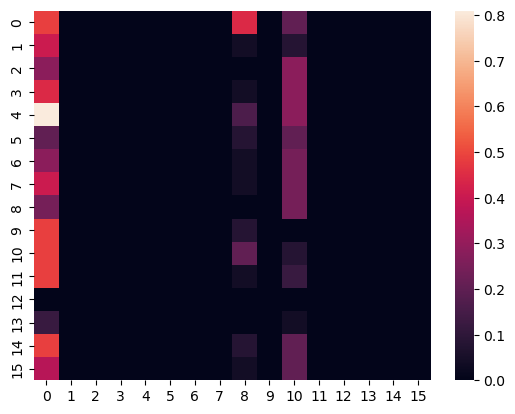

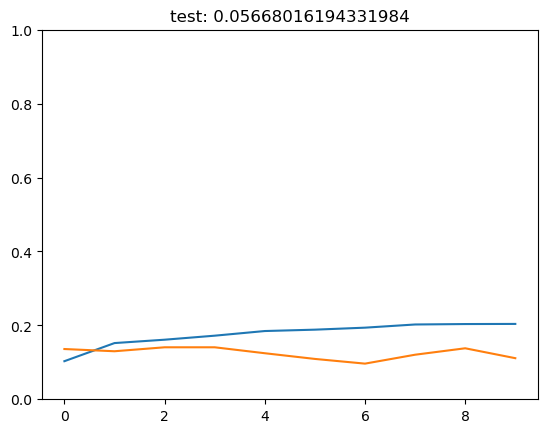

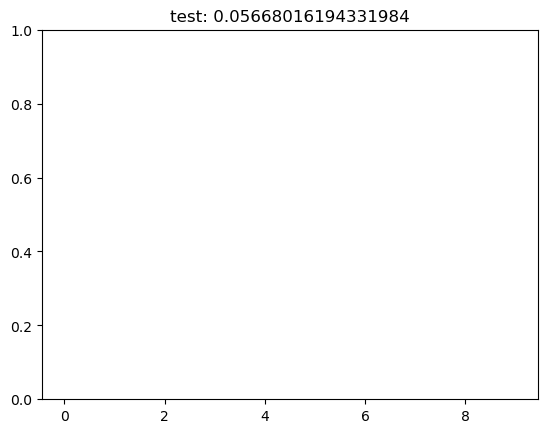

0:24:52.777244


In [13]:

train_pytorch.train(binary=False, batch_size = batch_size, num_epochs = 10, config=config, model = "2d", weights=None)

16


  0%|          | 0/5 [00:00<?, ?it/s]

..
..
..
..
..
Test Accuracy: 0.0567


(M2DCNN(
   (up_conv): Conv2d(
     (conv_block): Sequential(
       (0): Conv2d(73, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): mish()
       (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
       (5): mish()
       (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (front_conv): Conv2d(
     (conv_block): Sequential(
       (0): Conv2d(90, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): mish()
       (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
       (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)

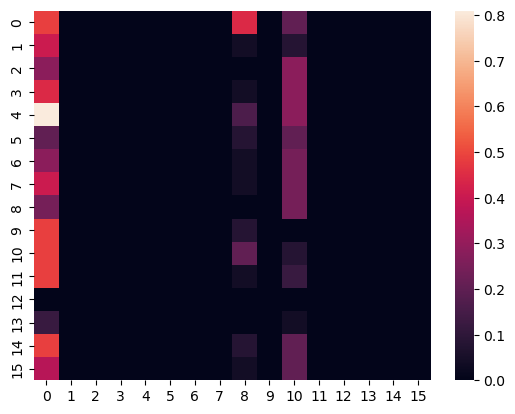

In [14]:
import model_m2dcnn as model
from torch.utils.data import DataLoader
from dataset import lpp_Dataset

batch_size = 50
binary = False
test_dataloader = DataLoader(lpp_Dataset("data/Test/"), batch_size=batch_size, shuffle=False)
if binary:
        nb_classes = 2
else:
    with open("label_dict.txt", "r") as f:
        nb_classes = len(f.readlines())
      
print(nb_classes)
train_pytorch.test(model.M2DCNN(numClass=nb_classes, numFeatues=30880, DIMX=74, DIMY=90, DIMZ=73), config,f"results/{config}_weights.pth", nb_classes, test_dataloader)